# 燃焼室圧およびノズル出口圧最適化

燃焼室圧およびノズル出口圧を最適化します．入力値を与えて実行すると，計算結果とグラフを表示します．

==================== simulation results ====================
max thrust = 481.1381480924547 (N)
max chamber pressure = 2.2541892592328794 (MPa)
burning time = 1.9324155193992492 (s)
total inpulse = 744.0312154020064 (Ns)
average thrust = 386.0314206146415 (N)
oxidizer consumption = 0.39337973632075707 (kg)
fuel consumption = 0.03349287485964173 (kg)
Isp = 177.85529125914474 (s)
final fuel port diameter = 28.192019888973867 (mm)
sliver ratio = 79.26862204880365 (%)
====================== execution time ======================
execution time = 11.90385999999853 (s)
Saved results as :result_202203031739.html
Saved thrust curve as :thrust_curve_202203031739.csv


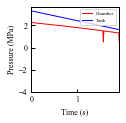

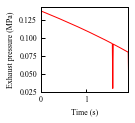

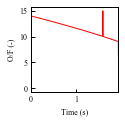

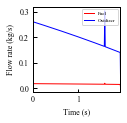

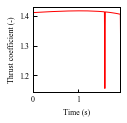

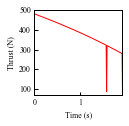

In [15]:
#! /usr/bin/env python
# coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize_scalar, minimize
import time
import csv
import base64
import datetime

dt_now = datetime.datetime.now()

def image_file_to_base64(file_path):
    with open(file_path, "rb") as image_file:
        data = base64.b64encode(image_file.read())

    return data.decode('utf-8')

if __name__ == '__main__':
 
    start_time = time.perf_counter()

    plt.rcParams['font.family'] ='Times new roman'#使用するフォント
    plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
    plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
    plt.rcParams['font.size'] = 8 #フォントの大きさ
    plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ

    # 入力値
    P_t_i = 3.3 		# 初期タンク圧 (MPa)
    P_t_f = 2.0 		# 最終タンク圧 (MPa)
    t_b_d = 1.49 		# 燃焼予定時間 (s)
    V_ox_i = 440 		# 酸化剤充填量 (cc)
    rho_ox = 895.67 	# 酸化剤密度 (kg/m^3)
    gamma_ox = 0 		# 酸化剤ガス比熱比 (-)
    D_o = 3.4 			# オリフィス径 (mm)
    C_d = 0.665	 		# 流量計数 (-)
    rho_f = 910 		# 燃料密度 (kg/m^3)
    L_f = 276 			# 燃料軸長 (mm)
    D_f_i = 25 			# 初期ポート径 (mm)
    D_f_out = 38 		# 燃料外径 (mm)
    N_port = 1 			# ポート数 (個)
    a = 1.04e-4 		# 酸化剤流速係数 (m^3/kg)
    n = 0.352 			# 酸化剤流速指数 (-)
    eta_c_star = 0.85 	# C*効率 (-)
    P_o = 0.1013 		# 背圧 (MPa)
    D_t_i = 14.0 		# 初期スロート径 (mm)
    D_e = 24.2 			# ノズル出口径 (mm)
    alpha = 15 			# ノズル開口半長角 (deg)
    r_dot_n = 0			# エロージョン速度 (mm/s)

    # シミュレーション設定
    simulation_time = 8							# シミュレーション時間 (s)
    Ts = 10e-3									# サンプリング周期 (s)
    t = np.linspace(0, simulation_time, int(simulation_time / Ts))
    m_ox = np.zeros([len(t), 1])				# 酸化剤消費量 (Kg)
    P_t = np.zeros([len(t), 1])					# タンク圧 (MPa)
    P_c = np.zeros([len(t), 1])					# 燃焼室圧 (MPa)
    m_dot_ox = np.zeros([len(t), 1])			# 酸化剤流量 (kg/s)
    m_f = np.zeros([len(t), 1])					# 燃料消費量 (kg)
    D_f = np.zeros([len(t), 1])					# ポート径 (mm)
    G_ox = np.zeros([len(t), 1])				# 酸化剤流速 (kg/m^2s)
    r_dot = np.zeros([len(t), 1])				# 燃料後退速度 (mm/s)
    m_dot_f = np.zeros([len(t), 1])				# 燃料流量 (kg/s)
    o_f = np.zeros([len(t), 1])					# OF比 (-)
    eta_c_star_c_star = np.zeros([len(t), 1])	# 特性排気速度 (m/s)
    gamma = np.zeros([len(t), 1])				# 比熱比 (-)
    D_t = np.zeros([len(t), 1])					# スロート径 (mm)
    P_e = np.zeros([len(t), 1])					# ノズル出口圧 (MPa)
    C_f = np.zeros([len(t), 1])					# 推力係数 (-)
    F_t = np.zeros([len(t), 1])					# 推力 (N)
    I_t = np.zeros([len(t), 1])					# 力積 (Ns)
    # P_c_d = np.zeros([len(t), 1])				# 燃焼室圧 (MPa)
    # diff_P_c_d = np.zeros([len(t), 1])		# 燃焼室圧誤差 (%)
    epsilon_d = np.zeros([len(t), 1])			# 開口比 (-)
    # diff_epsilon_d = np.zeros([len(t), 1])	# 開口比誤差 (%)

    # C*csvと比熱比csvを読み込み
    df_c_star = pd.read_csv('cstar.csv', header=0, index_col=0, dtype=np.float64)
    df_gamma = pd.read_csv('gamma.csv', header=0, index_col=0, dtype=np.float64)

    # シミュレーション (1ステップ目)
    def func1(x):
        xP_c, P_c_d = x[0], x[1]
        return abs((xP_c - P_c_d) / P_c_d * 100)

    def cons1(x):
        xP_c, P_c_d = x[0], x[1]
        m_ox[0, 0] = 0
        P_t[0, 0] = (P_t_f - P_t_i) * 0 / t_b_d + P_t_i
        if P_t[0, 0] > xP_c:
            diff_P = P_t[0, 0] - xP_c
        else:
            diff_P = 1e-6
        if m_ox[0, 0] <= V_ox_i * rho_ox * 1e-6:
            m_dot_ox[0, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
        else:
            m_dot_ox[0, 0] = 0
        m_f[0, 0] = 0
        D_f[0, 0] = math.sqrt(4 * m_f[0, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
        G_ox[0, 0] = 4 * m_dot_ox[0, 0] / (N_port * math.pi *(D_f[0, 0] * 1e-3)**2)
        r_dot[0, 0] = a * G_ox[0, 0]**n * 1e3
        m_dot_f[0, 0] = L_f * 1e-3 * math.pi * D_f[0, 0] * 1e-3 * rho_f * r_dot[0, 0] * 1e-3 * N_port
        o_f[0, 0] = m_dot_ox[0, 0] / m_dot_f[0, 0]
        if np.round(o_f[0, 0], 1) <= 0.5:
            index_o_f = 0.5
        elif np.round(o_f[0, 0], 1) >= 19.5:
            index_o_f = 19.5
        else:
            index_o_f = np.round(o_f[0, 0], 1)
        if np.round(xP_c, 1) <= 0.5:
            index_P_c = 0.5
        elif np.round(xP_c, 1) >= 4.9:
            index_P_c = 4.9
        else:
            index_P_c = np.round(xP_c, 1)
        eta_c_star_c_star[0, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
            + (o_f[0, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
            + (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
        gamma[0, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
            + (o_f[0, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
            + (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
        D_t[0, 0] = D_t_i
        P_e[0, 0] = 0.1
        v = P_c_d - (4 * eta_c_star_c_star[0, 0] * (m_dot_ox[0, 0] + m_dot_f[0, 0]) / (math.pi * D_t[0, 0]**2))
        return v

    cons = (
        {'type': 'eq', 'fun': cons1}
    )

    bounds = [[0.5, 5], [0.5, 5]]

    x_i = [0.5, 0.5]

    result = minimize(func1, x0=x_i, constraints=cons, bounds=bounds, method="SLSQP")
    P_c[0, 0] = result.x[0]

    def func2(xP_e):
        epsilon_d[0, 0] = ((2 / (gamma[0, 0] + 1))**(1 / (gamma[0, 0] - 1))) * ((P_c[0, 0] / xP_e)**(1 / gamma[0, 0])) / math.sqrt((gamma[0, 0] + 1) / (gamma[0, 0] - 1) * (1 - (xP_e / P_c[0, 0])**((gamma[0, 0] - 1) / gamma[0, 0])))
        v = abs((epsilon_d[0, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
        return v

    result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
    P_e[0, 0] = result.x
    C_f[0, 0] = math.sqrt(2 * gamma[0, 0]**2 / (gamma[0, 0] - 1) * ((2 / (gamma[0, 0] + 1))**((gamma[0, 0] + 1) / (gamma[0, 0] - 1))) * (1 - (P_e[0, 0] / P_c[0, 0])**((gamma[0, 0] - 1) / gamma[0, 0]))) \
        + ((P_e[0, 0] - P_o) / P_c[0, 0]) * ((D_e**2) / D_t_i**2)
    F_t[0, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[0, 0] * P_c[0, 0] * (math.pi * D_t_i**2 / 4)
    I_t[0, 0] = 0

    # シミュレーション (2ステップ目)
    def func1(x):
        xP_c, P_c_d = x[0], x[1]
        return abs((xP_c - P_c_d) / P_c_d * 100)

    def cons1(x):
        xP_c, P_c_d = x[0], x[1]
        m_ox[1, 0] = m_ox[0, 0] + m_dot_ox[0, 0] * Ts/2
        P_t[1, 0] = (P_t_f - P_t_i) * Ts / t_b_d + P_t_i
        if P_t[1, 0] > xP_c:
            diff_P = P_t[1, 0] - xP_c
        else:
            diff_P = 1e-6
        if m_ox[1, 0] <= V_ox_i * rho_ox * 1e-6:
            m_dot_ox[1, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
        else:
            m_dot_ox[1, 0] = 0
        m_f[1, 0] = m_f[0, 0] + m_dot_f[0, 0] * Ts/2
        D_f[1, 0] = math.sqrt(4 * m_f[1, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
        G_ox[1, 0] = 4 * m_dot_ox[1, 0] / (N_port * math.pi *(D_f[1, 0] * 1e-3)**2)
        r_dot[1, 0] = a * G_ox[1, 0]**n * 1e3
        m_dot_f[1, 0] = L_f * 1e-3 * math.pi * D_f[1, 0] * 1e-3 * rho_f * r_dot[1, 0] * 1e-3 * N_port
        o_f[1, 0] = m_dot_ox[1, 0] / m_dot_f[1, 0]
        if np.round(o_f[1, 0], 1) <= 0.5:
            index_o_f = 0.5
        elif np.round(o_f[1, 0], 1) >= 19.5:
            index_o_f = 19.5
        else:
            index_o_f = np.round(o_f[1, 0], 1)
        if np.round(xP_c, 1) <= 0.5:
            index_P_c = 0.5
        elif np.round(xP_c, 1) >= 4.9:
            index_P_c = 4.9
        else:
            index_P_c = np.round(xP_c, 1)
        eta_c_star_c_star[1, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
            + (o_f[1, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
            + (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
        gamma[1, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
            + (o_f[1, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
            + (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
        D_t[1, 0] = D_t[0, 0] - r_dot_n * Ts
        P_e[1, 0] = 0.1
        v = P_c_d - (4 * eta_c_star_c_star[1, 0] * (m_dot_ox[1, 0] + m_dot_f[1, 0]) / (math.pi * D_t[1, 0]**2))
        return v

    cons = (
        {'type': 'eq', 'fun': cons1}
    )

    bounds = [[0.5, 5], [0.5, 5]]

    x_i = [0.5, 0.5]

    result = minimize(func1, x0=x_i, constraints=cons, bounds=bounds, method="SLSQP")
    P_c[1, 0] = result.x[0]

    def func2(xP_e):
        epsilon_d[1, 0] = ((2 / (gamma[1, 0] + 1))**(1 / (gamma[1, 0] - 1))) * ((P_c[1, 0] / xP_e)**(1 / gamma[1, 0])) / math.sqrt((gamma[1, 0] + 1) / (gamma[1, 0] - 1) * (1 - (xP_e / P_c[1, 0])**((gamma[1, 0] - 1) / gamma[1, 0])))
        v = abs((epsilon_d[1, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
        return v

    result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
    P_e[1, 0] = result.x
    C_f[1, 0] = math.sqrt(2 * gamma[1, 0]**2 / (gamma[1, 0] - 1) * ((2 / (gamma[1, 0] + 1))**((gamma[1, 0] + 1) / (gamma[1, 0] - 1))) * (1 - (P_e[1, 0] / P_c[1, 0])**((gamma[1, 0] - 1) / gamma[1, 0]))) \
        + ((P_e[1, 0] - P_o) / P_c[1, 0]) * ((D_e**2) / (D_t_i**2))
    F_t[1, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[1, 0] * P_c[1, 0] * (math.pi * D_t_i**2 / 4)
    I_t[1, 0] = I_t[0, 0] + (F_t[0, 0] + F_t[1, 0]) * Ts/2

    # # # シミュレーション (3ステップ目以降)
    for k in range(2, len(t)):
        def func1(x):
            xP_c, P_c_d = x[0], x[1]
            return abs((xP_c - P_c_d) / P_c_d * 100)

        def cons1(x):
            xP_c, P_c_d = x[0], x[1]
            m_ox[k, 0] = m_ox[k-1, 0] + (m_dot_ox[k-1, 0] + m_dot_ox[k-2, 0]) * Ts/2
            P_t[k, 0] = (P_t_f - P_t_i) * Ts*k / t_b_d + P_t_i
            if P_t[k, 0] > xP_c:
                diff_P = P_t[k, 0] - xP_c
            else:
                diff_P = 1e-12
            if m_ox[k, 0] <= V_ox_i * rho_ox * 1e-6:
                m_dot_ox[k, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
            else:
                m_dot_ox[k, 0] = 1e-12
            m_f[k, 0] = m_f[k-1, 0] + (m_dot_f[k-1, 0] + m_dot_f[k-2, 0]) * Ts/2
            D_f[k, 0] = math.sqrt(4 * m_f[k, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
            G_ox[k, 0] = 4 * m_dot_ox[k, 0] / (N_port * math.pi *(D_f[k, 0] * 1e-3)**2)
            r_dot[k, 0] = a * G_ox[k, 0]**n * 1e3
            m_dot_f[k, 0] = L_f * 1e-3 * math.pi * D_f[k, 0] * 1e-3 * rho_f * r_dot[k, 0] * 1e-3 * N_port
            o_f[k, 0] = m_dot_ox[k, 0] / m_dot_f[k, 0]
            if np.round(o_f[k, 0], 1) <= 0.5:
                index_o_f = 0.5
            elif np.round(o_f[k, 0], 1) >= 19.5:
                index_o_f = 19.5
            else:
                index_o_f = np.round(o_f[k, 0], 1)
            if np.round(xP_c, 1) <= 0.5:
                index_P_c = 0.5
            elif np.round(xP_c, 1) >= 4.9:
                index_P_c = 4.9
            else:
                index_P_c = np.round(xP_c, 1)
            eta_c_star_c_star[k, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
                + (o_f[k, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
                + (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
            gamma[k, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
                + (o_f[k, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
                + (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
            D_t[k, 0] = D_t[k-1, 0] - r_dot_n * Ts
            P_e[k, 0] = 0.1
            v = P_c_d - (4 * eta_c_star_c_star[k, 0] * (m_dot_ox[k, 0] + m_dot_f[k, 0]) / (math.pi * D_t[k, 0]**2))
            return v

        cons = (
            {'type': 'eq', 'fun': cons1}
        )

        bounds = [[0.5, 5], [0.5, 5]]

        x_i = [0.5, 0.5]

        result = minimize(func1, x0=x_i, constraints=cons, bounds = bounds, method="SLSQP")
        P_c[k, 0] = result.x[0]

        def func2(xP_e):
            epsilon_d[k, 0] = ((2 / (gamma[k, 0] + 1))**(1 / (gamma[k, 0] - 1))) * ((P_c[k, 0] / xP_e)**(1 / gamma[k, 0])) / math.sqrt((gamma[k, 0] + 1) / (gamma[k, 0] - 1) * (1 - (xP_e / P_c[k, 0])**((gamma[k, 0] - 1) / gamma[k, 0])))
            v = abs((epsilon_d[k, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
            return v

        result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
        P_e[k, 0] = result.x
        C_f[k, 0] = math.sqrt(2 * gamma[k, 0]**2 / (gamma[k, 0] - 1) * ((2 / (gamma[k, 0] + 1))**((gamma[k, 0] + 1) / (gamma[k, 0] - 1))) * (1 - (P_e[k, 0] / P_c[0, 0])**((gamma[k, 0] - 1) / gamma[k, 0]))) \
            + ((P_e[k, 0] - P_o) / P_c[k, 0]) * ((D_e**2) / D_t_i**2)
        F_t[k, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[k, 0] * P_c[k, 0] * (math.pi * D_t_i**2 / 4)
        I_t[k, 0] = I_t[k-1, 0] + (F_t[k-1, 0] + F_t[k, 0]) * Ts/2

    # 出力値
    index_fin = np.argmin(abs(m_ox - (V_ox_i * rho_ox * 1e-6))) - 1
    F_max = np.max(F_t)
    P_cmax = np.max(P_c)
    P_c_ave = np.average(P_c[:index_fin])
    P_t_ave = np.average(P_t[:index_fin])
    t_b = t[index_fin]
    I_total = I_t[index_fin, 0]
    F_ave = np.average(F_t[:index_fin])
    mdot_ox_ave = np.average(m_ox[:index_fin])
    m_ox_total = m_ox[index_fin, 0]
    mdot_f_ave = np.average(m_f[:index_fin])
    m_f_total = m_f[index_fin, 0]
    r_dot_ave = np.average(r_dot[:index_fin])
    OF_ave = np.average(o_f[:index_fin])
    eta_c_star_c_star_ave = np.average(eta_c_star_c_star[:index_fin])
    C_f_ave = np.average(C_f[:index_fin])
    I_sp = I_total / ((m_ox_total + m_f_total) * 9.8)
    D_f_f = D_f[index_fin, 0]
    D_t_f = D_t_i + r_dot_n * t_b
    Lstar_i = L_f * ((N_port * D_f_i**2)/D_t_i**2)*0.001
    Lstar_f = L_f * ((N_port * D_f_f**2)/D_t_f**2)*0.001
    Phi = (1 - (N_port * D_f_f**2 - N_port * D_f_i**2) / (D_f_out**2 - N_port * D_f_i**2)) * 100
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time

    # 結果出力
    np.set_printoptions(formatter={'float': '{:.2f}'.format})
    print('==================== simulation results ====================')
    print(f'max thrust = {F_max} (N)')
    print(f'max chamber pressure = {P_cmax} (MPa)')
    print('============================================================')
    print(f'burning time = {t_b} (s)')
    print(f'total inpulse = {I_total} (Ns)')
    print(f'average thrust = {F_ave} (N)')
    print(f'oxidizer consumption = {m_ox_total} (kg)')
    print(f'fuel consumption = {m_f_total} (kg)')
    print(f'Isp = {I_sp} (s)')
    print(f'final fuel port diameter = {D_f_f} (mm)')
    print(f'sliver ratio = {Phi} (%)')
    print('====================== execution time ======================')
    print(f'execution time = {elapsed_time} (s)')
    

    # グラフ描画
    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, P_c, linestyle='-', color='r', linewidth=1.0, label='Chamber')
    plt.plot(t, P_t, linestyle='-', color='b', linewidth=1.0, label='Tank')
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (MPa)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    plt.legend(loc='upper right', frameon=True, fontsize=5)
    plt.savefig("./fig/pressure.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, P_e, linestyle='-', color='r', linewidth=1.0, label='pe')
    plt.xlabel('Time (s)')
    plt.ylabel('Exhaust pressure (MPa)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    # plt.legend(loc='upper left', frameon=True)
    plt.savefig("./fig/pe.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, o_f, linestyle='-', color='r', linewidth=1.0, label='o/f')
    plt.xlabel('Time (s)')
    plt.ylabel('O/F (-)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    # plt.legend(loc='upper left', frameon=True)
    plt.savefig("./fig/of.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, m_dot_f, linestyle='-', color='r', linewidth=1.0, label='Fuel')
    plt.plot(t, m_dot_ox, linestyle='-', color='b', linewidth=1.0, label='Oxidizer')
    plt.xlabel('Time (s)')
    plt.ylabel('Flow rate (kg/s)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    plt.legend(loc='upper right', frameon=True, fontsize=5)
    plt.savefig("./fig/mdot.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, C_f, linestyle='-', color='r', linewidth=1.0, label='cf')
    plt.xlabel('Time (s)')
    plt.ylabel('Thrust coefficient (-)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    # plt.legend(loc='upper left', frameon=True)
    plt.savefig("./fig/cf.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, F_t, linestyle='-', color='r', linewidth=1.0, label='thrust')
    plt.xlabel('Time (s)')
    plt.ylabel('Thrust (N)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    # plt.legend(loc='upper left', frameon=True)
    plt.savefig("./fig/thrust.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)
    
    #結果をhtmlで出力
    html = '''
    <html>
    <head>
    <meta charset="utf-8">
    <title>{title1}</title>
    </head>
    <body>
    <table border="1" style="border-collapse: collapse">
	<tr>
		<td>入力値</td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td>出力値</td>
		<td></td>
		<td></td>
	</tr>
	<tr>
		<td>初期タンク圧</td>
		<td>P<sub>t,i</sub>[MPa]</td>
		<td>{P_t_i}</td>
		<td colspan="4"></td>
		<td></td>
		<td>燃焼時間</td>
		<td>t<sub>b</sub>[s]</td>
		<td>{t_b}</td>
	</tr>
	<tr>
		<td>最終タンク圧</td>
		<td>P<sub>t,f</sub>[MPa]</td>
		<td>{P_t_f}</td>
		<td colspan="4"></td>
		<td></td>
		<td>トータルインパルス</td>
		<td>I [N·s]</td>
		<td>{I}</td>
	</tr>
	<tr>
		<td>燃焼予定時間</td>
		<td>t<sub>b</sub>' [s]</td>
		<td>{t_b_d}</td>
		<td colspan="4"></td>
		<td></td>
		<td>平均推力</td>
		<td>F<sub>ave</sub>[N]</td>
		<td>{F_ave}</td>
	</tr>
	<tr>
		<td>酸化剤充填量</td>
		<td>V<sub>ox,i</sub>[cc]</td>
		<td>{V_ox}</td>
		<td colspan="4"></td>
		<td></td>
		<td>酸化剤消費量</td>
		<td>m<sub>ox</sub>[kg]</td>
		<td>{m_ox}</td>
	</tr>
	<tr>
		<td>酸化剤密度</td>
		<td>ρ<sub>ox</sub>[kg/m<sup>3</sup>]</td>
		<td>{rho_ox}</td>
		<td colspan="4">飽和蒸気圧3.0 MPaの沸点における密度</td>
		<td></td>
		<td>燃料消費量</td>
		<td>m<sub>f</sub>[kg]</td>
		<td>{m_f}</td>
	</tr>
	<tr>
		<td>酸化剤ガス 比熱比</td>
		<td>γ<sub>ox</sub>[-]</td>
		<td>{gamma_ox}</td>
		<td colspan="4">飽和蒸気圧4.0, 2.5 MPa における値の平均</td>
		<td></td>
		<td>比推力</td>
		<td>I<sub>sp</sub>[s]</td>
		<td>{I_sp}</td>
	</tr>
	<tr>
		<td>オリフィス径</td>
		<td>D<sub>o</sub>[mm]</td>
		<td>{D_o}</td>
		<td colspan="4"></td>
		<td></td>
		<td>最終燃料ポート径</td>
		<td>D<sub>f,f</sub>[mm]</td>
		<td>{D_f_f}</td>
	</tr>
	<tr>
		<td>流量係数</td>
		<td>C<sub>d</sub>[-]</td>
		<td>{C_d}</td>
		<td colspan="4"></td>
		<td></td>
		<td>スライバ率</td>
		<td>Φ [%]</td>
		<td>{phi}</td>
	</tr>
	<tr>
		<td>燃料密度</td>
		<td>ρ<sub>f</sub>[kg/m<sup>3</sup>]</td>
		<td>{rho_f}</td>
		<td colspan="4"></td>
		<td></td>
		<td>平均タンク圧力</td>
		<td>P<sub>t</sub>[MPa]</td>
		<td>{P_t}</td>
	</tr>
	<tr>
		<td>燃料軸長</td>
		<td>L<sub>f</sub>[mm]</td>
		<td>{L_f}</td>
		<td colspan="4"></td>
		<td></td>
		<td>平均酸化剤流量</td>
		<td>m<sub>dot,ox</sub>[kg/s]</td>
		<td>{m_dot_ox}</td>
	</tr>
	<tr>
		<td>初期ポート径</td>
		<td>D<sub>f,i</sub>[mm]</td>
		<td>{D_f_i}</td>
		<td colspan="4"></td>
		<td></td>
		<td>平均燃料流量</td>
		<td>m<sub>dot,f</sub>[kg/s]</td>
		<td>{m_dot_f}</td>
	</tr>
	<tr>
		<td>燃料外径</td>
		<td>D<sub>f,out</sub>[mm]</td>
		<td>{D_f_out}</td>
		<td colspan="4"></td>
		<td></td>
		<td>平均燃料後退速度</td>
		<td>r<sub>dot</sub><sub></sub>[mm/s]</td>
		<td>{r_dot}</td>
	</tr>
	<tr>
		<td>ポート数</td>
		<td>N [個]</td>
		<td>{N}</td>
		<td colspan="4"></td>
		<td></td>
		<td>平均O/F</td>
		<td>[-]</td>
		<td>{OF_ave}</td>
	</tr>
	<tr>
		<td>酸化剤流束係数</td>
		<td>a [m<sup>3</sup>/kg]</td>
		<td>{a}</td>
		<td colspan="4"></td>
		<td></td>
		<td>平均燃焼室圧</td>
		<td>P<sub>c</sub>[MPa]</td>
		<td>{P_c}</td>
	</tr>
	<tr>
		<td>酸化剤流束指数</td>
		<td>n [-]</td>
		<td>{n}</td>
		<td colspan="4"></td>
		<td></td>
		<td>平均特性排気速度</td>
		<td>c* [m/s]</td>
		<td>{cstar}</td>
	</tr>
	<tr>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td>平均推力係数</td>
		<td>C<sub>F</sub>[-]</td>
		<td>{C_F}</td>
	</tr>
	<tr>
		<td>c*効率</td>
		<td>η<sub>c*</sub>[-]</td>
		<td>{eta_cstar}</td>
		<td colspan="4"></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
	</tr>
	<tr>
		<td>背圧</td>
		<td>P<sub>0</sub>[MPa]</td>
		<td>{P_o}</td>
		<td colspan="4"></td>
		<td></td>
		<td>最終スロート径</td>
		<td>D<sub>t,f</sub>[mm]</td>
		<td>{D_t_f}</td>
	</tr>
	<tr>
		<td>初期スロート径</td>
		<td>D<sub>t,i</sub>[mm]</td>
		<td>{D_t_i}</td>
		<td colspan="4"></td>
		<td></td>
		<td>初期燃焼室特性長</td>
		<td>L*<sub>i</sub>[m]</td>
		<td>{Lstar_i}</td>
	</tr>
	<tr>
		<td>ノズル出口径</td>
		<td>D<sub>e</sub>[mm]</td>
		<td>{D_e}</td>
		<td colspan="4"></td>
		<td></td>
		<td>最終燃焼室特性長</td>
		<td>L*<sub>f</sub>[m]</td>
		<td>{Lstar_f}</td>
	</tr>
	<tr>
		<td>ノズル開口半頂角</td>
		<td>α [deg]</td>
		<td>{alpha}</td>
		<td colspan="4"></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
	</tr>
	<tr>
		<td>エロージョン速度</td>
		<td>r<sub>dot,n</sub><sub></sub>[mm/s]</td>
		<td>{r_dot_n}</td>
		<td colspan="4"></td>
		<td></td>
		<td>最大推力</td>
		<td>Fmax[N]</td>
		<td>{F_max}</td>
	</tr>
	<tr>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td></td>
		<td>最大燃焼室圧</td>
		<td>Pcmax[MPa]</td>
		<td>{P_cmax}</td>
	</tr>
</table>

    <img src="data:image/ping;base64,{image1}" />
    <img src="data:image/ping;base64,{image2}" />
    <img src="data:image/ping;base64,{image3}" />
    <img src="data:image/ping;base64,{image4}" />
    <img src="data:image/ping;base64,{image5}" />
    <img src="data:image/ping;base64,{image6}" />
    </body>
    </html>
    '''.format( title1 = "simulation result" ,image1 = image_file_to_base64("./fig/Pressure.png"), image2 = image_file_to_base64("./fig/Pe.png"), image3 = image_file_to_base64("./fig/of.png"), image4 = image_file_to_base64("./fig/mdot.png"), image5 = image_file_to_base64("./fig/cf.png"), image6 = image_file_to_base64("./fig/thrust.png"), P_t_i = P_t_i, P_t_f = P_t_f, t_b_d = t_b_d, V_ox = V_ox_i, rho_ox = rho_ox, gamma_ox = gamma_ox, D_o = D_o, C_d = C_d, rho_f = rho_f, L_f = L_f, D_f_i = D_f_i, D_f_out = D_f_out, N = N_port, a = a, n = n, eta_cstar = eta_c_star, P_o = P_o, D_t_i = D_t_i, D_t_f = D_t_f, D_e = D_e, alpha = alpha, r_dot_n = r_dot_n, F_max = F_max, P_cmax = P_cmax, t_b = t_b, I = I_total, F_ave = F_ave, m_ox =m_ox_total, m_f = m_f_total, I_sp = I_sp, D_f_f = D_f_f, phi = Phi, P_t = P_t_ave, m_dot_ox = mdot_ox_ave, m_dot_f = mdot_f_ave, r_dot = r_dot_ave, OF_ave = OF_ave, P_c = P_c_ave, cstar = eta_c_star_c_star_ave, C_F = C_f_ave, Lstar_i = Lstar_i, Lstar_f = Lstar_f) 

    with open('./result/result_' + dt_now.strftime('%Y%m%d%H%M') + '.html', mode='w', encoding='utf8') as f:
        f.write(html)
    print('Saved results as :' + 'result_' + dt_now.strftime('%Y%m%d%H%M') + '.html')

    #推力履歴をcsvで出力
    thrust_curve = np.zeros((int(index_fin),2))
    for i in list(range(index_fin)):
        thrust_curve[i][0] = t[i]
        thrust_curve[i][1] = F_t[i]
    with open('./result/thrust_curve' + dt_now.strftime('%Y%m%d%H%M') + '.csv', mode='w', newline = '') as f:
        writer = csv.writer(f)
        writer.writerow(['Time[s]','Thrust[N]'])
        writer.writerows(thrust_curve)
    print('Saved thrust curve as :' + 'thrust_curve_' + dt_now.strftime('%Y%m%d%H%M') + '.csv')
    
    
    

# 燃焼時間最適化

燃焼時間を最適化します．計算結果とグラフを表示します．
先に燃焼室圧およびノズル出口圧最適化を実行してください．

==================== simulation results ====================
max thrust = 413.5148630071588 (N)
max chamber pressure = 2.591354312125727 (MPa)
burning time = 2.2528160200250316 (s)
total inpulse = 779.7988567100049 (Ns)
average thrust = 347.3478664021868 (N)
oxidizer consumption = 0.39440697165347954 (kg)
fuel consumption = 0.03715918893048075 (kg)
Isp = 184.37801472088248 (s)
final fuel port diameter = 28.51974982259409 (mm)
sliver ratio = 76.99925153316781 (%)
====================== execution time ======================
execution time = 76.61079149999932 (s)
loop times = 4 (-)
Saved results as :result_202203031637.html
Saved thrust curve as :thrust_curve_202203031637.csv


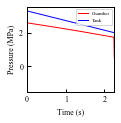

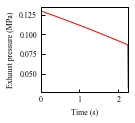

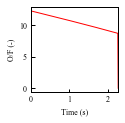

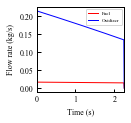

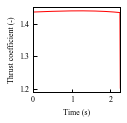

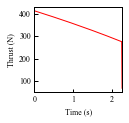

In [11]:
#! /usr/bin/env python
# coding: utf-8

def image_file_to_base64(file_path):
    with open(file_path, "rb") as image_file:
        data = base64.b64encode(image_file.read())

    return data.decode('utf-8')


if __name__ == '__main__':
    start_time = time.perf_counter()

    t_b = simulation_time
    looptimes = 0

    while (abs(t_b - t_b_d) > Ts) and (looptimes < 10):
        # シミュレーション (1ステップ目)
        def func1(x):
            xP_c, P_c_d = x[0], x[1]
            return abs((xP_c - P_c_d) / P_c_d * 100)

        def cons1(x):
            xP_c, P_c_d = x[0], x[1]
            m_ox[0, 0] = 0
            P_t[0, 0] = (P_t_f - P_t_i) * 0 / t_b_d + P_t_i
            if P_t[0, 0] > xP_c:
                diff_P = P_t[0, 0] - xP_c
            else:
                diff_P = 1e-6
            if m_ox[0, 0] <= V_ox_i * rho_ox * 1e-6:
                m_dot_ox[0, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
            else:
                m_dot_ox[0, 0] = 0
            m_f[0, 0] = 0
            D_f[0, 0] = math.sqrt(4 * m_f[0, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
            G_ox[0, 0] = 4 * m_dot_ox[0, 0] / (N_port * math.pi *(D_f[0, 0] * 1e-3)**2)
            r_dot[0, 0] = a * G_ox[0, 0]**n * 1e3
            m_dot_f[0, 0] = L_f * 1e-3 * math.pi * D_f[0, 0] * 1e-3 * rho_f * r_dot[0, 0] * 1e-3 * N_port
            o_f[0, 0] = m_dot_ox[0, 0] / m_dot_f[0, 0]
            if np.round(o_f[0, 0], 1) <= 0.5:
                index_o_f = 0.5
            elif np.round(o_f[0, 0], 1) >= 19.5:
                index_o_f = 19.5
            else:
                index_o_f = np.round(o_f[0, 0], 1)
            if np.round(xP_c, 1) <= 0.5:
                index_P_c = 0.5
            elif np.round(xP_c, 1) >= 4.9:
                index_P_c = 4.9
            else:
                index_P_c = np.round(xP_c, 1)
            eta_c_star_c_star[0, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
                + (o_f[0, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
                + (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
            gamma[0, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
                + (o_f[0, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
                + (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
            D_t[0, 0] = D_t_i
            P_e[0, 0] = 0.1
            v = P_c_d - (4 * eta_c_star_c_star[0, 0] * (m_dot_ox[0, 0] + m_dot_f[0, 0]) / (math.pi * D_t[0, 0]**2))
            return v

        cons = (
            {'type': 'eq', 'fun': cons1}
        )

        bounds = [[0.5, 5], [0.5, 5]]

        x_i = [0.5, 0.5]

        result = minimize(func1, x0=x_i, constraints=cons, bounds=bounds, method="SLSQP")
        P_c[0, 0] = result.x[0]

        def func2(xP_e):
            epsilon_d[0, 0] = ((2 / (gamma[0, 0] + 1))**(1 / (gamma[0, 0] - 1))) * ((P_c[0, 0] / xP_e)**(1 / gamma[0, 0])) / math.sqrt((gamma[0, 0] + 1) / (gamma[0, 0] - 1) * (1 - (xP_e / P_c[0, 0])**((gamma[0, 0] - 1) / gamma[0, 0])))
            v = abs((epsilon_d[0, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
            return v

        result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
        P_e[0, 0] = result.x
        C_f[0, 0] = math.sqrt(2 * gamma[0, 0]**2 / (gamma[0, 0] - 1) * ((2 / (gamma[0, 0] + 1))**((gamma[0, 0] + 1) / (gamma[0, 0] - 1))) * (1 - (P_e[0, 0] / P_c[0, 0])**((gamma[0, 0] - 1) / gamma[0, 0]))) \
            + ((P_e[0, 0] - P_o) / P_c[0, 0]) * ((D_e**2) / D_t_i**2)
        F_t[0, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[0, 0] * P_c[0, 0] * (math.pi * D_t_i**2 / 4)
        I_t[0, 0] = 0

        # シミュレーション (2ステップ目)
        def func1(x):
            xP_c, P_c_d = x[0], x[1]
            return abs((xP_c - P_c_d) / P_c_d * 100)

        def cons1(x):
            xP_c, P_c_d = x[0], x[1]
            m_ox[1, 0] = m_ox[0, 0] + m_dot_ox[0, 0] * Ts/2
            P_t[1, 0] = (P_t_f - P_t_i) * Ts / t_b_d + P_t_i
            if P_t[1, 0] > xP_c:
                diff_P = P_t[1, 0] - xP_c
            else:
                diff_P = 1e-6
            if m_ox[1, 0] <= V_ox_i * rho_ox * 1e-6:
                m_dot_ox[1, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
            else:
                m_dot_ox[1, 0] = 0
            m_f[1, 0] = m_f[0, 0] + m_dot_f[0, 0] * Ts/2
            D_f[1, 0] = math.sqrt(4 * m_f[1, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
            G_ox[1, 0] = 4 * m_dot_ox[1, 0] / (N_port * math.pi *(D_f[1, 0] * 1e-3)**2)
            r_dot[1, 0] = a * G_ox[1, 0]**n * 1e3
            m_dot_f[1, 0] = L_f * 1e-3 * math.pi * D_f[1, 0] * 1e-3 * rho_f * r_dot[1, 0] * 1e-3 * N_port
            o_f[1, 0] = m_dot_ox[1, 0] / m_dot_f[1, 0]
            if np.round(o_f[1, 0], 1) <= 0.5:
                index_o_f = 0.5
            elif np.round(o_f[1, 0], 1) >= 19.5:
                index_o_f = 19.5
            else:
                index_o_f = np.round(o_f[1, 0], 1)
            if np.round(xP_c, 1) <= 0.5:
                index_P_c = 0.5
            elif np.round(xP_c, 1) >= 4.9:
                index_P_c = 4.9
            else:
                index_P_c = np.round(xP_c, 1)
            eta_c_star_c_star[1, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
                + (o_f[1, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
                + (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
            gamma[1, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
                + (o_f[1, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
                + (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
            D_t[1, 0] = D_t[0, 0] - r_dot_n * Ts
            P_e[1, 0] = 0.1
            v = P_c_d - (4 * eta_c_star_c_star[1, 0] * (m_dot_ox[1, 0] + m_dot_f[1, 0]) / (math.pi * D_t[1, 0]**2))
            return v

        cons = (
            {'type': 'eq', 'fun': cons1}
        )

        bounds = [[0.5, 5], [0.5, 5]]

        x_i = [0.5, 0.5]

        result = minimize(func1, x0=x_i, constraints=cons, bounds=bounds, method="SLSQP")
        P_c[1, 0] = result.x[0]

        def func2(xP_e):
            epsilon_d[1, 0] = ((2 / (gamma[1, 0] + 1))**(1 / (gamma[1, 0] - 1))) * ((P_c[1, 0] / xP_e)**(1 / gamma[1, 0])) / math.sqrt((gamma[1, 0] + 1) / (gamma[1, 0] - 1) * (1 - (xP_e / P_c[1, 0])**((gamma[1, 0] - 1) / gamma[1, 0])))
            v = abs((epsilon_d[1, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
            return v

        result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
        P_e[1, 0] = result.x
        C_f[1, 0] = math.sqrt(2 * gamma[1, 0]**2 / (gamma[1, 0] - 1) * ((2 / (gamma[1, 0] + 1))**((gamma[1, 0] + 1) / (gamma[1, 0] - 1))) * (1 - (P_e[1, 0] / P_c[1, 0])**((gamma[1, 0] - 1) / gamma[1, 0]))) \
            + ((P_e[1, 0] - P_o) / P_c[1, 0]) * ((D_e**2) / (D_t_i**2))
        F_t[1, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[1, 0] * P_c[1, 0] * (math.pi * D_t_i**2 / 4)
        I_t[1, 0] = I_t[0, 0] + (F_t[0, 0] + F_t[1, 0]) * Ts/2

        # # # シミュレーション (3ステップ目以降)
        for k in range(2, len(t)):
            def func1(x):
                xP_c, P_c_d = x[0], x[1]
                return abs((xP_c - P_c_d) / P_c_d * 100)

            def cons1(x):
                xP_c, P_c_d = x[0], x[1]
                m_ox[k, 0] = m_ox[k-1, 0] + (m_dot_ox[k-1, 0] + m_dot_ox[k-2, 0]) * Ts/2
                P_t[k, 0] = (P_t_f - P_t_i) * Ts*k / t_b_d + P_t_i
                if P_t[k, 0] > xP_c:
                    diff_P = P_t[k, 0] - xP_c
                else:
                    diff_P = 1e-12
                if m_ox[k, 0] <= V_ox_i * rho_ox * 1e-6:
                    m_dot_ox[k, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
                else:
                    m_dot_ox[k, 0] = 1e-12
                m_f[k, 0] = m_f[k-1, 0] + (m_dot_f[k-1, 0] + m_dot_f[k-2, 0]) * Ts/2
                D_f[k, 0] = math.sqrt(4 * m_f[k, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
                G_ox[k, 0] = 4 * m_dot_ox[k, 0] / (N_port * math.pi *(D_f[k, 0] * 1e-3)**2)
                r_dot[k, 0] = a * G_ox[k, 0]**n * 1e3
                m_dot_f[k, 0] = L_f * 1e-3 * math.pi * D_f[k, 0] * 1e-3 * rho_f * r_dot[k, 0] * 1e-3 * N_port
                o_f[k, 0] = m_dot_ox[k, 0] / m_dot_f[k, 0]
                if np.round(o_f[k, 0], 1) <= 0.5:
                    index_o_f = 0.5
                elif np.round(o_f[k, 0], 1) >= 19.5:
                    index_o_f = 19.5
                else:
                    index_o_f = np.round(o_f[k, 0], 1)
                if np.round(xP_c, 1) <= 0.5:
                    index_P_c = 0.5
                elif np.round(xP_c, 1) >= 4.9:
                    index_P_c = 4.9
                else:
                    index_P_c = np.round(xP_c, 1)
                eta_c_star_c_star[k, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
                    + (o_f[k, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
                    + (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
                gamma[k, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
                    + (o_f[k, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
                    + (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
                D_t[k, 0] = D_t[k-1, 0] - r_dot_n * Ts
                P_e[k, 0] = 0.1
                v = P_c_d - (4 * eta_c_star_c_star[k, 0] * (m_dot_ox[k, 0] + m_dot_f[k, 0]) / (math.pi * D_t[k, 0]**2))
                return v

            cons = (
                {'type': 'eq', 'fun': cons1}
            )

            bounds = [[0.5, 5], [0.5, 5]]

            x_i = [0.5, 0.5]

            result = minimize(func1, x0=x_i, constraints=cons, bounds = bounds, method="SLSQP")
            P_c[k, 0] = result.x[0]

            def func2(xP_e):
                epsilon_d[k, 0] = ((2 / (gamma[k, 0] + 1))**(1 / (gamma[k, 0] - 1))) * ((P_c[k, 0] / xP_e)**(1 / gamma[k, 0])) / math.sqrt((gamma[k, 0] + 1) / (gamma[k, 0] - 1) * (1 - (xP_e / P_c[k, 0])**((gamma[k, 0] - 1) / gamma[k, 0])))
                v = abs((epsilon_d[k, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
                return v

            result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
            P_e[k, 0] = result.x
            C_f[k, 0] = math.sqrt(2 * gamma[k, 0]**2 / (gamma[k, 0] - 1) * ((2 / (gamma[k, 0] + 1))**((gamma[k, 0] + 1) / (gamma[k, 0] - 1))) * (1 - (P_e[k, 0] / P_c[0, 0])**((gamma[k, 0] - 1) / gamma[k, 0]))) \
                + ((P_e[k, 0] - P_o) / P_c[k, 0]) * ((D_e**2) / D_t_i**2)
            F_t[k, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[k, 0] * P_c[k, 0] * (math.pi * D_t_i**2 / 4)
            I_t[k, 0] = I_t[k-1, 0] + (F_t[k-1, 0] + F_t[k, 0]) * Ts/2
        index_fin = np.argmin(abs(m_ox - (V_ox_i * rho_ox * 1e-6)))
        t_b = t[index_fin]
        t_b_d = t_b
        for k in range(2, len(t)):
            result = minimize(func1, x0=x_i, constraints=cons, bounds = bounds, method="SLSQP")
            P_c[k, 0] = result.x[0]
            result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
            P_e[k, 0] = result.x
            C_f[k, 0] = math.sqrt(2 * gamma[k, 0]**2 / (gamma[k, 0] - 1) * ((2 / (gamma[k, 0] + 1))**((gamma[k, 0] + 1) / (gamma[k, 0] - 1))) * (1 - (P_e[k, 0] / P_c[0, 0])**((gamma[k, 0] - 1) / gamma[k, 0]))) \
                + ((P_e[k, 0] - P_o) / P_c[k, 0]) * ((D_e**2) / D_t_i**2)
            F_t[k, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[k, 0] * P_c[k, 0] * (math.pi * D_t_i**2 / 4)
            I_t[k, 0] = I_t[k-1, 0] + (F_t[k-1, 0] + F_t[k, 0]) * Ts/2
        index_fin = np.argmin(abs(m_ox - (V_ox_i * rho_ox * 1e-6)))
        t_b = t[index_fin]
        looptimes += 1

    # 出力値
    F_max = np.max(F_t)
    P_cmax = np.max(P_c)
    index_fin = np.argmin(abs(m_ox - (V_ox_i * rho_ox * 1e-6)))
    t_b = t[index_fin]
    I_total = I_t[index_fin, 0]
    F_ave = np.average(F_t[:index_fin])
    m_ox_total = m_ox[index_fin, 0]
    m_f_total = m_f[index_fin, 0]
    I_sp = I_total / ((m_ox_total + m_f_total) * 9.8)
    D_f_f = D_f[index_fin, 0]
    Phi = (1 - (N_port * D_f_f**2 - N_port * D_f_i**2) / (D_f_out**2 - N_port * D_f_i**2)) * 100
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time

    # 結果出力
    np.set_printoptions(formatter={'float': '{:.2f}'.format})
    print('==================== simulation results ====================')
    print(f'max thrust = {F_max} (N)')
    print(f'max chamber pressure = {P_cmax} (MPa)')
    print('============================================================')
    print(f'burning time = {t_b} (s)')
    print(f'total inpulse = {I_total} (Ns)')
    print(f'average thrust = {F_ave} (N)')
    print(f'oxidizer consumption = {m_ox_total} (kg)')
    print(f'fuel consumption = {m_f_total} (kg)')
    print(f'Isp = {I_sp} (s)')
    print(f'final fuel port diameter = {D_f_f} (mm)')
    print(f'sliver ratio = {Phi} (%)')
    print('====================== execution time ======================')
    print(f'execution time = {elapsed_time} (s)')
    print(f'loop times = {looptimes} (-)')


    # グラフ描画
    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, P_c, linestyle='-', color='r', linewidth=1.0, label='Chamber')
    plt.plot(t, P_t, linestyle='-', color='b', linewidth=1.0, label='Tank')
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (MPa)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    plt.legend(loc='upper right', frameon=True, fontsize=5)
    plt.savefig("./fig/pressure.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, P_e, linestyle='-', color='r', linewidth=1.0, label='pe')
    plt.xlabel('Time (s)')
    plt.ylabel('Exhaust pressure (MPa)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    # plt.legend(loc='upper left', frameon=True)
    plt.savefig("./fig/pe.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, o_f, linestyle='-', color='r', linewidth=1.0, label='o/f')
    plt.xlabel('Time (s)')
    plt.ylabel('O/F (-)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    # plt.legend(loc='upper left', frameon=True)
    plt.savefig("./fig/of.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, m_dot_f, linestyle='-', color='r', linewidth=1.0, label='Fuel')
    plt.plot(t, m_dot_ox, linestyle='-', color='b', linewidth=1.0, label='Oxidizer')
    plt.xlabel('Time (s)')
    plt.ylabel('Flow rate (kg/s)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    plt.legend(loc='upper right', frameon=True, fontsize=5)
    plt.savefig("./fig/mdot.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, C_f, linestyle='-', color='r', linewidth=1.0, label='cf')
    plt.xlabel('Time (s)')
    plt.ylabel('Thrust coefficient (-)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    # plt.legend(loc='upper left', frameon=True)
    plt.savefig("./fig/cf.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

    plt.figure(figsize=(1.57,1.57))
    plt.plot(t, F_t, linestyle='-', color='r', linewidth=1.0, label='thrust')
    plt.xlabel('Time (s)')
    plt.ylabel('Thrust (N)')
    plt.xlim(0, t_b)
    # plt.ylim(0, 6e38)
    # plt.xticks(np.arange(0, 31, 5))
    # plt.yticks(np.arange(0, 6e38, 1e38))
    # plt.legend(loc='upper left', frameon=True)
    plt.savefig("./fig/thrust.png", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)


    #結果をhtmlで出力
    html = '''
    <html>
    <head>
    <meta charset="utf-8">
    <title>{title1}</title>
    </head>
    <body>
    <table border="1" style="border-collapse: collapse">
    <tr>
        <td>入力値</td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td>出力値</td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td>初期タンク圧</td>
        <td>P<sub>t,i</sub>[MPa]</td>
        <td>{P_t_i}</td>
        <td colspan="4"></td>
        <td></td>
        <td>燃焼時間</td>
        <td>t<sub>b</sub>[s]</td>
        <td>{t_b}</td>
    </tr>
    <tr>
        <td>最終タンク圧</td>
        <td>P<sub>t,f</sub>[MPa]</td>
        <td>{P_t_f}</td>
        <td colspan="4"></td>
        <td></td>
        <td>トータルインパルス</td>
        <td>I [N·s]</td>
        <td>{I}</td>
    </tr>
    <tr>
        <td>燃焼予定時間</td>
        <td>t<sub>b</sub>' [s]</td>
        <td>{t_b_d}</td>
        <td colspan="4"></td>
        <td></td>
        <td>平均推力</td>
        <td>F<sub>ave</sub>[N]</td>
        <td>{F_ave}</td>
    </tr>
    <tr>
        <td>酸化剤充填量</td>
        <td>V<sub>ox,i</sub>[cc]</td>
        <td>{V_ox}</td>
        <td colspan="4"></td>
        <td></td>
        <td>酸化剤消費量</td>
        <td>m<sub>ox</sub>[kg]</td>
        <td>{m_ox}</td>
    </tr>
    <tr>
        <td>酸化剤密度</td>
        <td>ρ<sub>ox</sub>[kg/m<sup>3</sup>]</td>
        <td>{rho_ox}</td>
        <td colspan="4">飽和蒸気圧3.0 MPaの沸点における密度</td>
        <td></td>
        <td>燃料消費量</td>
        <td>m<sub>f</sub>[kg]</td>
        <td>{m_f}</td>
    </tr>
    <tr>
        <td>酸化剤ガス 比熱比</td>
        <td>γ<sub>ox</sub>[-]</td>
        <td>{gamma_ox}</td>
        <td colspan="4">飽和蒸気圧4.0, 2.5 MPa における値の平均</td>
        <td></td>
        <td>比推力</td>
        <td>I<sub>sp</sub>[s]</td>
        <td>{I_sp}</td>
    </tr>
    <tr>
        <td>オリフィス径</td>
        <td>D<sub>o</sub>[mm]</td>
        <td>{D_o}</td>
        <td colspan="4"></td>
        <td></td>
        <td>最終燃料ポート径</td>
        <td>D<sub>f,f</sub>[mm]</td>
        <td>{D_f_f}</td>
    </tr>
    <tr>
        <td>流量係数</td>
        <td>C<sub>d</sub>[-]</td>
        <td>{C_d}</td>
        <td colspan="4"></td>
        <td></td>
        <td>スライバ率</td>
        <td>Φ [%]</td>
        <td>{phi}</td>
    </tr>
    <tr>
        <td>燃料密度</td>
        <td>ρ<sub>f</sub>[kg/m<sup>3</sup>]</td>
        <td>{rho_f}</td>
        <td colspan="4"></td>
        <td></td>
        <td>平均タンク圧力</td>
        <td>P<sub>t</sub>[MPa]</td>
        <td>{P_t}</td>
    </tr>
    <tr>
        <td>燃料軸長</td>
        <td>L<sub>f</sub>[mm]</td>
        <td>{L_f}</td>
        <td colspan="4"></td>
        <td></td>
        <td>平均酸化剤流量</td>
        <td>m<sub>dot,ox</sub>[kg/s]</td>
        <td>{m_dot_ox}</td>
    </tr>
    <tr>
        <td>初期ポート径</td>
        <td>D<sub>f,i</sub>[mm]</td>
        <td>{D_f_i}</td>
        <td colspan="4"></td>
        <td></td>
        <td>平均燃料流量</td>
        <td>m<sub>dot,f</sub>[kg/s]</td>
        <td>{m_dot_f}</td>
    </tr>
    <tr>
        <td>燃料外径</td>
        <td>D<sub>f,out</sub>[mm]</td>
        <td>{D_f_out}</td>
        <td colspan="4"></td>
        <td></td>
        <td>平均燃料後退速度</td>
        <td>r<sub>dot</sub><sub></sub>[mm/s]</td>
        <td>{r_dot}</td>
    </tr>
    <tr>
        <td>ポート数</td>
        <td>N [個]</td>
        <td>{N}</td>
        <td colspan="4"></td>
        <td></td>
        <td>平均O/F</td>
        <td>[-]</td>
        <td>{OF_ave}</td>
    </tr>
    <tr>
        <td>酸化剤流束係数</td>
        <td>a [m<sup>3</sup>/kg]</td>
        <td>{a}</td>
        <td colspan="4"></td>
        <td></td>
        <td>平均燃焼室圧</td>
        <td>P<sub>c</sub>[MPa]</td>
        <td>{P_c}</td>
    </tr>
    <tr>
        <td>酸化剤流束指数</td>
        <td>n [-]</td>
        <td>{n}</td>
        <td colspan="4"></td>
        <td></td>
        <td>平均特性排気速度</td>
        <td>c* [m/s]</td>
        <td>{cstar}</td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td>平均推力係数</td>
        <td>C<sub>F</sub>[-]</td>
        <td>{C_F}</td>
    </tr>
    <tr>
        <td>c*効率</td>
        <td>η<sub>c*</sub>[-]</td>
        <td>{eta_cstar}</td>
        <td colspan="4"></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td>背圧</td>
        <td>P<sub>0</sub>[MPa]</td>
        <td>{P_o}</td>
        <td colspan="4"></td>
        <td></td>
        <td>最終スロート径</td>
        <td>D<sub>t,f</sub>[mm]</td>
        <td>{D_t_f}</td>
    </tr>
    <tr>
        <td>初期スロート径</td>
        <td>D<sub>t,i</sub>[mm]</td>
        <td>12.00</td>
        <td colspan="4"></td>
        <td></td>
        <td>初期燃焼室特性長</td>
        <td>L*<sub>i</sub>[m]</td>
        <td>{Lstar_i}</td>
    </tr>
    <tr>
        <td>ノズル出口径</td>
        <td>D<sub>e</sub>[mm]</td>
        <td>22.20</td>
        <td colspan="4"></td>
        <td></td>
        <td>最終燃焼室特性長</td>
        <td>L*<sub>f</sub>[m]</td>
        <td>{Lstar_f}</td>
    </tr>
    <tr>
        <td>ノズル開口半頂角</td>
        <td>α [deg]</td>
        <td>{alpha}</td>
        <td colspan="4"></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td>エロージョン速度</td>
        <td>r<sub>dot,n</sub><sub></sub>[mm/s]</td>
        <td>{r_dot_n}</td>
        <td colspan="4"></td>
        <td></td>
        <td>最大推力</td>
        <td>Fmax[N]</td>
        <td>{F_max}</td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td>最大燃焼室圧</td>
        <td>Pcmax[MPa]</td>
        <td>{P_cmax}</td>
    </tr>
    </table>

    <img src="data:image/ping;base64,{image1}" />
    <img src="data:image/ping;base64,{image2}" />
    <img src="data:image/ping;base64,{image3}" />
    <img src="data:image/ping;base64,{image4}" />
    <img src="data:image/ping;base64,{image5}" />
    <img src="data:image/ping;base64,{image6}" />
    </body>
    </html>
    '''.format( title1 = "simulation result" ,image1 = image_file_to_base64("./fig/Pressure.png"), image2 = image_file_to_base64("./fig/Pe.png"), image3 = image_file_to_base64("./fig/of.png"), image4 = image_file_to_base64("./fig/mdot.png"), image5 = image_file_to_base64("./fig/cf.png"), image6 = image_file_to_base64("./fig/thrust.png"), P_t_i = P_t_i, P_t_f = P_t_f, t_b_d = t_b_d, V_ox = V_ox_i, rho_ox = rho_ox, gamma_ox = gamma_ox, D_o = D_o, C_d = C_d, rho_f = rho_f, L_f = L_f, D_f_i = D_f_i, D_f_out = D_f_out, N = N_port, a = a, n = n, eta_cstar = eta_c_star, P_o = P_o, D_t_i = D_t_i, D_e = D_e, alpha = alpha, r_dot_n = r_dot_n, F_max = F_max, P_cmax = P_cmax, t_b = t_b, I = I_total, F_ave = F_ave, m_ox =m_ox_total, m_f = m_f_total, I_sp = I_sp, D_f_f = D_f_f, phi = Phi, P_t = P_t_ave, m_dot_ox = mdot_ox_ave, m_dot_f = mdot_f_ave, r_dot = r_dot_ave, OF_ave = OF_ave, P_c = P_c_ave, cstar = eta_c_star_c_star_ave, C_F = C_f_ave, Lstar_i = Lstar_i, Lstar_f = Lstar_f, D_t_f = D_t_f) 

    with open('./result/result_' + dt_now.strftime('%Y%m%d%H%M') + '.html', mode='w', encoding='utf8') as f:
        f.write(html)
    print('Saved results as :' + 'result_' + dt_now.strftime('%Y%m%d%H%M') + '.html')

    #推力履歴をcsvで出力
    thrust_curve = np.zeros((int(index_fin),2))
    for i in list(range(index_fin)):
        thrust_curve[i][0] = t[i]
        thrust_curve[i][1] = F_t[i]
    with open('./result/thrust_curve' + dt_now.strftime('%Y%m%d%H%M') + '.csv', mode='w', newline = '') as f:
        writer = csv.writer(f)
        writer.writerow(['Time[s]','Thrust[N]'])
        writer.writerows(thrust_curve)
    print('Saved thrust curve as :' + 'thrust_curve_' + dt_now.strftime('%Y%m%d%H%M') + '.csv')


# 燃焼試験結果との比較

燃焼試験結果をcsv形式で読み込み，シミュレーションの結果と比較します．

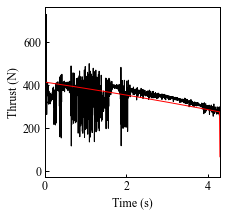

In [15]:
df_thrust = pd.read_csv('./comparecsv/pp_0210.csv', header=0, dtype=np.float64)

plt.figure(figsize=(3.14,3.14))
plt.plot(df_thrust['time'], df_thrust['thrust'], linestyle='-', color='k', linewidth=1.0, label='test')
plt.plot(t, F_t, linestyle='-', color='r', linewidth=1.0, label='sim')
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
# plt.legend(loc='upper left', frameon=True)
plt.savefig("./fig/compare_thrust.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)